# Configurações iniciais

In [1]:
import numpy as np
import pandas as pd
import os
import cv2 as cv

np.random.seed(42)


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(fig_id, format='png', dpi=600)

Vamos agora importar o [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database)


In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)

Vamos instanciar as features do problemas em uma matriz X e os rótulos no vetor y

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [6]:
col=list(mnist.data.columns)
type(col)

list

Vamos agora pegar um dígito, redimensionar em 28 por 28 pixels e visualizar essa imagem.


pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Name: 1300, Length: 784, dtype: int64
Saving figure some_digit_plot


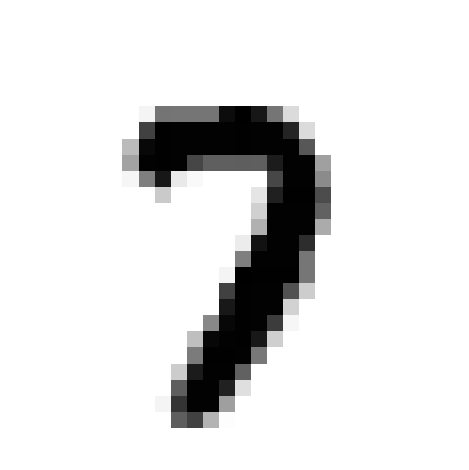

In [10]:
some_digit = X.iloc[1300]
print(some_digit)
some_digit_image = some_digit.to_numpy().reshape(28, 28)

plt.imshow(some_digit_image,
           cmap = mpl.cm.binary,
           interpolation= 'nearest')

plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [11]:
y.iloc[1300]

7

In [12]:
def plot_digit(data):
       image = data.to_numpy().reshape(28, 28)
       plt.imshow(image,
              cmap = mpl.cm.binary,
              interpolation= 'nearest')
       plt.axis("off")
       return plt.show()

# Sepração treiro e teste

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#Data augmentation

Nesta seção, apresentamos as técnicas de data augmentation empregadas para ampliar a diversidade do conjunto de dados e aprimorar a capacidade de generalização do modelo. Especificamente, aumentaremos nosso conjunto de treino aplicando translações aleatórias de até 5 pixels e rotações aleatórias de até 30°.

### Definindo uma função de translação randomica

In [14]:
import random
from scipy.ndimage import shift

def random_shift(image):
    dx = random.randint(-5, 5)
    dy = random.randint(-5, 5)
    image = np.array(image).reshape(28, 28)
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    shifted_image = shifted_image.reshape([-1])
    return shifted_image

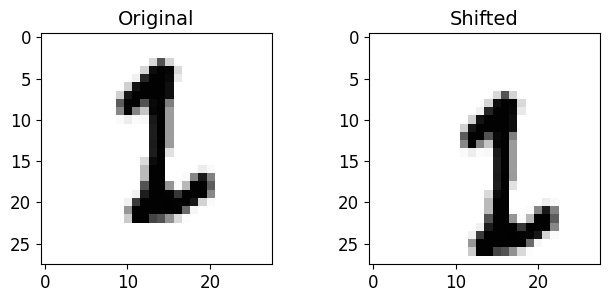

In [15]:
image = X_train.iloc[70]

new_image = random_shift(image)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(np.array(image).reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted", fontsize=14)
plt.imshow(np.array(new_image).reshape(28, 28), interpolation="nearest", cmap="Greys")


### Definindo uma função de rotação randomica

In [17]:
from scipy.ndimage import rotate
def random_rotate(image):
    angle = random.randint(-30, 30)
    image = image.to_numpy().reshape(28, 28)
    rotated_image = rotate(image, angle, reshape=False, cval=0, order=1)
    return pd.DataFrame(rotated_image.reshape(1,784),columns=col)


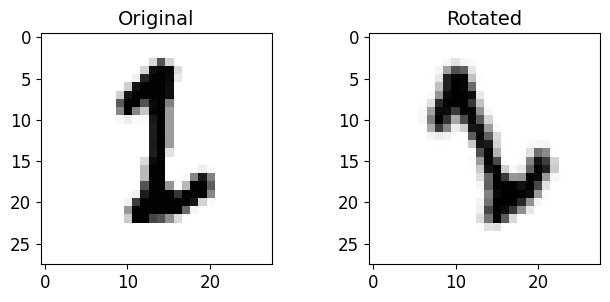

In [18]:
image = X_train.iloc[70]
rotated_image = random_rotate(image)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(np.array(image).reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Rotated", fontsize=14)
plt.imshow(np.array(rotated_image).reshape(28, 28), interpolation="nearest", cmap="Greys")

### Ampliando nosso conjunto de treino

In [26]:
def augment_dataset(dataset, labels, col_names, percentage):

    n_original = len(dataset)
    n_augmented = int(n_original * percentage)

    augmented_images = []
    augmented_labels = []

    for i in range(n_augmented):
        idx = random.randint(0, n_original - 1)
        image = dataset.iloc[idx]
        label = labels[idx]


        augmented_image = random_shift(random_rotate(image))
        augmented_images.append(augmented_image.flatten())
        augmented_labels.append(label)

    augmented_dataset = pd.DataFrame(augmented_images, columns=col_names)
    augmented_labels = pd.Series(augmented_labels)

    return augmented_dataset, augmented_labels

Vamo usar a função definida acima para ampliar nosso conjunto em 20%

In [27]:
col_names = X_train.columns
augmented_X, augmented_y = augment_dataset(X_train, y_train, col_names, percentage=0.2)


X_train_augmented = pd.concat([X_train, augmented_X], ignore_index=True)
y_train_augmented = pd.concat([y_train, augmented_y], ignore_index=True)

In [28]:
print(X_train_augmented.shape)
print(y_train_augmented.shape)

(72000, 784)
(72000,)


In [29]:
X_train_augmented

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71998,0,0,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,0,0,0


In [39]:
shuffle_index = np.random.permutation(X_train_augmented.shape[0])
X_train_augmented, y_train_augmented = X_train_augmented.iloc[shuffle_index], y_train_augmented.iloc[shuffle_index]

# Multiclass Classification

## OvR

Vamos fazer uma otimização através dos seguintes parâmetros:

loss : ['hinge', 'log']

alpha: [1e-4, 1e-2, 1]

In [41]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('std_scaler', StandardScaler()),
                 ('estimator', SGDClassifier(max_iter = 10, random_state=42))
             ])

param_grid = [{'estimator__loss' : ['hinge', 'log'],
               'estimator__alpha': [1e-4,5e-4,8e-4,9e-4,1e-3,2e-3,3e-3,5e-3,1e-2,1e-1,1],
               }]

grid_search = GridSearchCV(pipe, param_grid, cv=5, verbose=10, n_jobs=-1)
grid_search.fit(X_train_augmented, y_train_augmented)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
55 fits failed out of a total of 110.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyt

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('estimator',
                                        SGDClassifier(max_iter=10,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid=[{'estimator__alpha': [0.0001, 0.0005, 0.0008, 0.0009,
                                               0.001, 0.002, 0.003, 0.005, 0.01,
                                               0.1, 1],
                          'estimator__loss': ['hinge', 'log']}],
             verbose=10)

Vamos agora visualizar os resultados

In [46]:
results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
                     pd.DataFrame(grid_search.cv_results_['std_test_score'],
                                  columns=["Std"]),
                     pd.DataFrame(grid_search.cv_results_["mean_test_score"],
                                  columns=["Score"])],axis=1)

results.sort_values("Score", ascending=False) #Ordenamento decrescente

,estimator__alpha,estimator__loss,Std,Score
6,0.0009,hinge,0.004167,0.8942
4,0.0008,hinge,0.005477,0.8940
10,0.0020,hinge,0.004775,0.8940
2,0.0005,hinge,0.004020,0.8928
8,0.0010,hinge,0.004167,0.8928
0,0.0001,hinge,0.004317,0.8926
14,0.0050,hinge,0.003774,0.8924
12,0.0030,hinge,0.003311,0.8918
16,0.0100,hinge,0.002871,0.8906
18,0.1000,hinge,0.009847,0.8842


Vamos agora treinar um modelo com os melhores parametros do GridSearch.

In [47]:
model = Pipeline([('std_scaler', StandardScaler()),
                 ('estimator', SGDClassifier(max_iter = 10, random_state=42))
             ])

model.set_params(**grid_search.best_params_) #Introduz no pipeline os parametros


Pipeline(steps=[('std_scaler', StandardScaler()),
                ('estimator',
                 SGDClassifier(alpha=0.0009, max_iter=10, random_state=42))])

In [51]:
#Treinando o modelo
model.fit(X_train_augmented, y_train_augmented)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Pipeline(steps=[('std_scaler', StandardScaler()),
                ('estimator',
                 SGDClassifier(alpha=0.0009, max_iter=10, random_state=42))])

In [52]:
scores_grid

array([0.896, 0.901, 0.891, 0.889, 0.894])

## OvO

In [53]:
#classe que implementa OvO na força
from sklearn.multiclass import OneVsOneClassifier

#Vamos aumentar o número de iterações.
#Lembra que na técnica OvO há mais treinamentos mas pode ser interessante
#quando o modelo sofre com a escala

model = Pipeline([('std_scaler', StandardScaler()),
                 ('estimator', SGDClassifier(max_iter = 1000, random_state=42))
             ])

model.set_params(**grid_search.best_params_)
ovo_clf = OneVsOneClassifier(model)

In [54]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(ovo_clf, X_train_augmented, y_train_augmented, cv=5)

In [55]:
scores

array([0.911, 0.893, 0.892, 0.899, 0.911])

In [56]:
np.mean(scores)

0.9012

In [57]:
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  warnings.warn(


array([7], dtype=int8)

Agora vamos preparar o nosso modelo para uma avaliação final no conjunto de teste.

In [58]:
from sklearn.metrics  import confusion_matrix

In [59]:
y_pred = ovo_clf.predict(X_test)
conf_mx = confusion_matrix(y_test, y_pred)
conf_mx

array([[ 950,    0,   11,    4,    2,    5,    5,    2,    1,    0],
       [   0, 1099,   12,    4,    0,    1,    2,    3,   14,    0],
       [   3,    2,  970,   10,    3,    3,    9,    6,   24,    2],
       [   3,    0,   13,  944,    2,   13,    2,    7,   24,    2],
       [   2,    1,   15,    3,  922,    0,    4,    7,    8,   20],
       [   8,    0,    7,   38,    4,  790,   11,    0,   31,    3],
       [   9,    3,   19,    3,    4,   17,  899,    1,    3,    0],
       [   1,    3,   22,   15,    5,    0,    0,  961,    7,   14],
       [   4,    1,   10,   24,    8,   24,    4,    4,  885,   10],
       [   6,    4,    4,    9,   33,    6,    0,   30,   17,  900]])

In [60]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.932